## 异常检测
高斯模型来检测数据集中未标记的示例是否应被视为异常

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
# 获取数据
data = loadmat('../data/andrew_ml_ex85033/ex8data1.mat')
X = data['X']
X.shape

(307, 2)

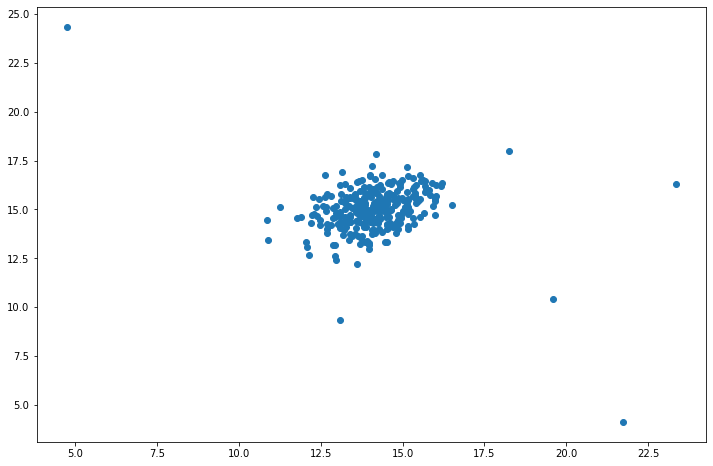

In [2]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
plt.show()

In [20]:
mu = X.mean(axis=0)
sigma=X.var(axis=0)
# -np.power((X-mu),2)/2*(sigma**2)
# np.exp(-np.power((X-mu),2)/2*(sigma**2))

In [58]:
# # 高斯分布,计算期望和方差带入公式
def  estimate_gaussian(mu,sigma,data):
    first = 1/(np.sqrt(2*np.pi)*sigma)
    second = np.exp(-np.power((data-mu),2)/(2*(sigma**2)))
    #累乘
    # p= np.multiply.reduce(first*second,axis=-1)
    return first*second

In [60]:
# 测试我们公式是否写的正确
from scipy import stats
dist = stats.norm(mu[0], sigma[0])
dist.pdf(15),estimate_gaussian(mu[0], sigma[0],15)

(0.1935875044615038, 0.19358750446150377)

In [61]:
mu = X.mean(axis=0)
sigma=X.var(axis=0)
z=estimate_gaussian(mu,sigma,X)
z.shape

(307, 2)

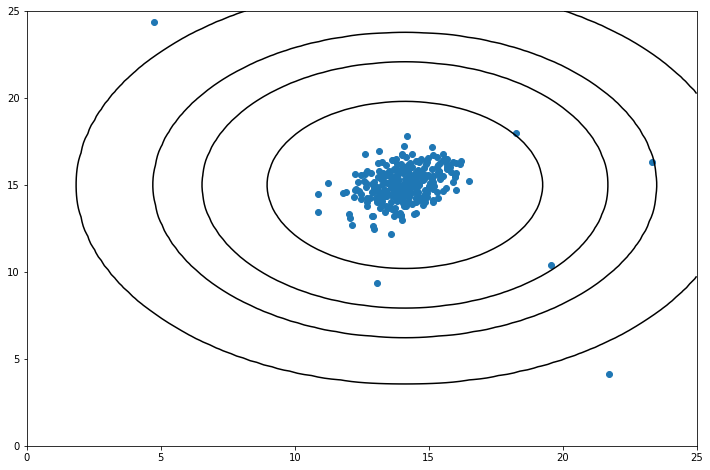

In [63]:
# 作图展示
x1 = np.linspace(0, 25, 100)
x2 = np.linspace(0, 25, 100)
Xplot, Yplot = np.meshgrid(x1,x2)
p1 = estimate_gaussian(mu[0],sigma[0],Xplot)
p2 = estimate_gaussian(mu[1],sigma[1],Yplot)
z = p1*p2 # 独立同分布乘法
fig, ax = plt.subplots(figsize=(12,8))
contour = plt.contour(Xplot, Yplot, z,[10**-11, 10**-7, 10**-5, 10**-3, 0.1],colors='black')
ax.scatter(X[:,0], X[:,1])
plt.show()


### 选择阈值ε
估计每组数据的概率，低概率的数据点更可能是异常的。确定异常点需要先确定一个阈值，我们可以通过验证集集来确定这个阈值。

In [64]:
# 交叉验证集
Xval = data['Xval']
yval = data['yval']

Xval.shape, yval.shape

((307, 2), (307, 1))

In [146]:
# 根据交叉验证集，获取合适的ε（异常点为1）
def chose_ep(prval,y):
    best_ep = 0
    best_f1=0
    epsilons = np.arange(prval.min(),prval.max(), (prval.max() - prval.min())/100)
    F1=[]
    for ep in epsilons:
        preds =( prval< ep ) #小于ep为出现异常点，预测记做1
        TP=np.sum(np.logical_and(preds==1,y==1)).astype(float)# True Positive,TP：预测为真，实际为真
        # TN=np.sum(np.logical_and(preds==0,y==0)).astype(float)#（True Negative,TN）：预测为假，实际为假
        FP=np.sum(np.logical_and(preds==1,y==0)).astype(float)# 错误肯定（False Positive,FP）：预测为真，实际为假
        FN=np.sum(np.logical_and(preds==0,y==1)).astype(float)# 错误否定（False Negative,FN）：预测为假，实际为真
        Precision=TP/(TP+FP)
        Recall=TP/(TP+FN)
        f1= (2*Precision*Recall)/(Precision+Recall)
        # print(TP,FP,FN,Precision,Recall,f1)
        if f1 > best_f1:
            best_f1=f1
            best_ep=ep
        F1.append(f1)
    return epsilons,np.array(F1),best_f1,best_ep
    

In [147]:
prval =  np.multiply.reduce(estimate_gaussian(mu,sigma,Xval),axis=1)
# (prval.max() - prval.min())/1000
epsilons,F1,best_f1,best_ep = chose_ep(prval,yval[:,0])
best_f1,best_ep

(0.8750000000000001, 0.0005079304543459431)

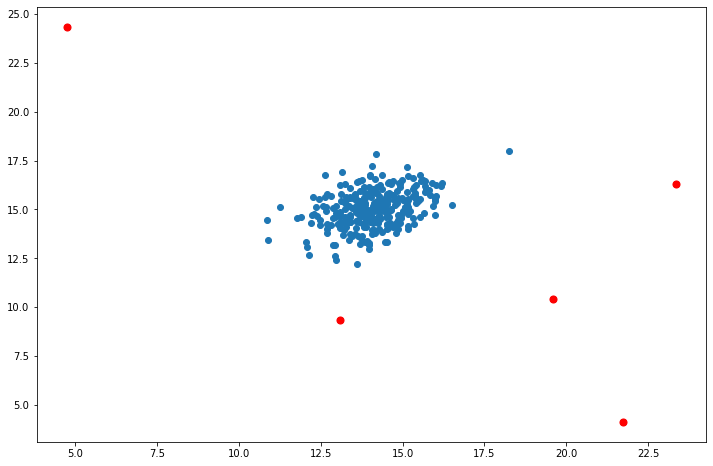

In [149]:
# 使用优化的ep
p= np.multiply.reduce(estimate_gaussian(mu,sigma,X),axis=1)
outliers = np.where(p < best_ep)# 挑选异常点
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers,0], X[outliers,1], s=50, color='r', marker='o')
plt.show()

红点是被标记为异常值的点。 这些看起来很合理。 有一些分离（但没有被标记）的右上角也可能是一个异常值，但是相当接近。

In [160]:
# 接下来我们用多远高斯函数模拟
def m_gs_pram(X):
    m=X.shape[0]
    X=np.matrix(X)
    mmu=X.mean(axis=0)
    msigma = (1/m)*(X-mmu).T*(X-mmu)
    return mmu,msigma


In [245]:
mmu,msigma = m_gs_pram(X)
mmu.shape,msigma.shape

((1, 2), (2, 2))

In [232]:
#多元高斯函数
# stats.multivariate_normal data一条数据
def m_gs(mmu,msigma,Xi):
    mmu = np.matrix(mmu.T)
    data=np.matrix(Xi.reshape((2,1)))# C R（2*1）
    n=data.shape[0]
    first = 1/(np.power(2*np.pi,n/2)*np.sqrt(np.linalg.det(msigma)))
    second = np.exp(-(1/2)*(data-mmu).T*np.linalg.inv(msigma)*(data-mmu))
    return first*second


In [234]:
mp = m_gs(mmu,msigma,Xval[2,:])
mp
# np.matrix(Xval[0,:]).shape
# np.matrix(mmu.T).shape

matrix([[0.03732495]])

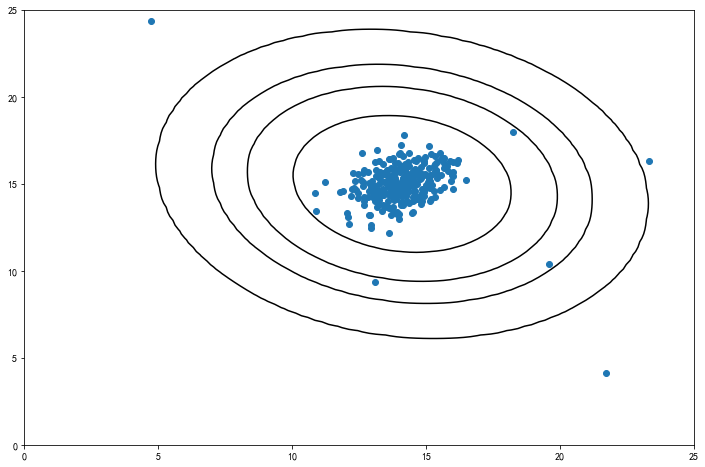

In [248]:
# 作图展示
x1 = np.linspace(0, 25, 100)
x2 = np.linspace(0, 25, 100)
Xplot, Yplot = np.meshgrid(x1,x2)
x = np.stack((Xplot, Yplot), axis=2)
# p = m_gs(mmu,msigma,data)
norm = stats.multivariate_normal(X.mean(axis=0), msigma)
p = norm.pdf(x)
fig, ax = plt.subplots(figsize=(12,8))
contour = plt.contour(Xplot, Yplot, p,[10**-11, 10**-7, 10**-5, 10**-3, 0.1],colors='black')
ax.scatter(X[:,0], X[:,1])
plt.show()


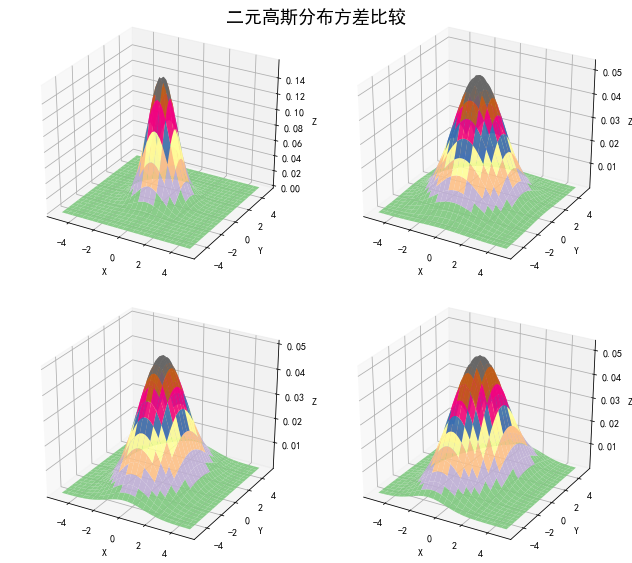

In [249]:
# 几种对比
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
if __name__ == '__main__':
    x1, x2 = np.mgrid[-5:5:51j, -5:5:51j]
    x = np.stack((x1, x2), axis=2)
    mpl.rcParams['axes.unicode_minus'] = False
    mpl.rcParams['font.sans-serif'] = 'SimHei'
    plt.figure(figsize=(9, 8), facecolor='w')
    sigma = (np.identity(2), np.diag((3,3)), np.diag((2,5)), np.array(((2,1), (1,5))))
    for i in np.arange(4):
        ax = plt.subplot(2, 2, i+1, projection='3d')
        norm = stats.multivariate_normal((0, 0), sigma[i])
        y = norm.pdf(x)
        ax.plot_surface(x1, x2, y, cmap=cm.Accent, rstride=2, cstride=2, alpha=0.9, lw=0.3)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    plt.suptitle('二元高斯分布方差比较', fontsize=18)
    plt.tight_layout(1.5)
    plt.show()

## 推荐算法


推荐引擎使用基于项目和用户的相似性度量来检查用户的历史偏好，以便为用户可能感兴趣的新“事物”提供建议。在本练习中，我们将实现一种称为协作过滤的特定推荐系统算法，并将其应用于 电影评分的数据集。


In [3]:
data = loadmat('../data/andrew_ml_ex85033/ex8_movies.mat')
#Y是包含从1到5的等级的（数量的电影x数量的用户）数组.R是包含指示用户是否给电影评分的二进制值的“指示符”数组。 两者应该具有相同的维度。
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [4]:
# Y是包含从1到5的等级的（数量的电影x数量的用户）数组.R是包含指示用户是否给电影评分的二进制值的“指示符”数组。 两者应该具有相同的维度。
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

In [5]:
#电影i的平均得分
Y[1,np.where(R[1,:]==1)].mean()

3.2061068702290076

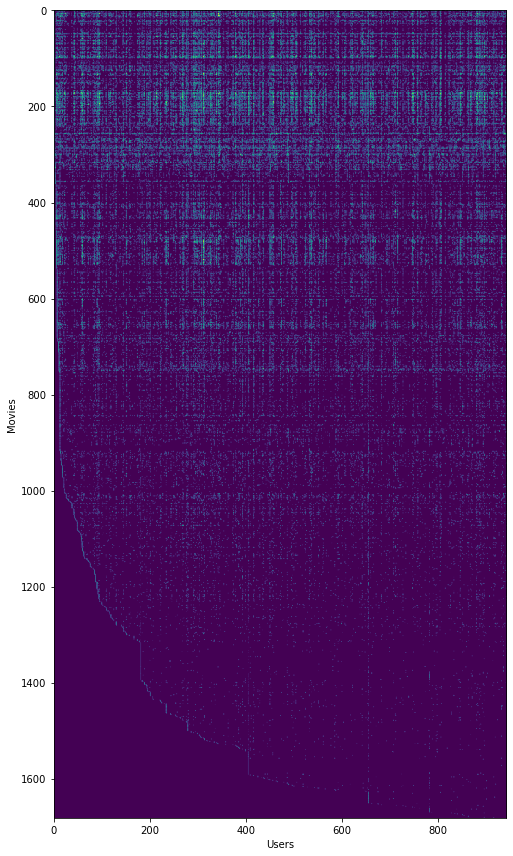

In [6]:
# 可以通过将矩阵渲染成图像来尝试“可视化”数据。 我们不能从这里收集太多，但它确实给我们了解用户和电影的相对密度。
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()
plt.show()

* cost 函数


$$
J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)})=\frac{1}{2}\sum_{(i,j):r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2+\frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^{n}(x_k^{(i)})^2+\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^{n}(\theta_k^{(j)})^2
$$

In [50]:
# 为方便调用api
def serialize(X, theta):
    """序列化两个矩阵
    """
    # X (movie, feature), (1682, 10): movie features
    # theta (user, feature), (943, 10): user preference
    return np.concatenate((X.ravel(), theta.ravel()))


def deserialize(param, n_movie, n_user, n_features):
    """逆序列化"""
    return param[:n_movie * n_features].reshape(n_movie, n_features), param[n_movie * n_features:].reshape(n_user, n_features)

In [51]:
def cost(theta,x,y,R):
    #根据公式
    theta = np.matrix(theta)
    x=np.matrix(x)
    y=np.matrix(y)
    inner = np.multiply(x*theta.T-y,R)
    return np.power(inner,2).sum()/2
def regularized_cost(theta,x,y,R,lam=1):
    ncost = cost(theta,x,y,R)
    reg_term = lam*(np.power(x,2).sum() + np.power(theta,2).sum())/2
    return ncost+reg_term
# 使用param参数的方式
def cost_p(param, Y, R, n_features):
    """compute cost for every r(i, j)=1
    Args:
        param: serialized X, theta
        Y (movie, user), (1682, 943): (movie, user) rating
        R (movie, user), (1682, 943): (movie, user) has rating
    """
    n_movie, n_user = Y.shape
    X, theta = deserialize(param, n_movie, n_user, n_features)
    inner = np.multiply(X @ theta.T - Y, R)
    return np.power(inner, 2).sum() / 2

def regularized_cost_p(param, Y, R, n_features, l=1):
    reg_term = np.power(param, 2).sum() * (l / 2)
    return cost_p(param, Y, R, n_features) + reg_term

In [8]:
# 为了测试这一点，我们提供了一组我们可以评估的预训练参数。 
params_data = loadmat('../data/andrew_ml_ex85033/ex8_movieParams.mat')
X = params_data['X']
theta = params_data['Theta']
X.shape, theta.shape

((1682, 10), (943, 10))

In [31]:
# 为了保持评估时间的少点，我们将只看一小段数据。
users = 4
movies = 5
features = 3
X_sub = X[:movies, :features]
theta_sub = theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]
# param_sub = serialize(X_sub, theta_sub)
print(cost(theta_sub, X_sub,Y_sub, R_sub),regularized_cost(theta_sub, X_sub,Y_sub, R_sub,1.5))



22.224603725685675 31.34405624427422


In [152]:
# 梯段
def gradient(theta,x,y,R):
    theta = np.matrix(theta)
    x=np.matrix(x)
    y=np.matrix(y)
    inner = np.multiply(x*theta.T-y,R)
    # X_grad (1682, 10)
    X_grad = inner @ theta
    # theta_grad (943, 10)
    theta_grad = inner.T @ X
    return X_grad,theta_grad
def  regularized_gradient(theta,x,y,R,l=1):
        X_grad,theta_grad=gradient(theta,x,y,R)
        return X_grad+l*x,theta_grad+l*theta
# 带参数param方式
def gradient_p(param, Y, R, n_features):
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movies, n_user = Y.shape
    X, theta = deserialize(param, n_movies, n_user, n_features)
    inner = np.multiply(X @ theta.T - Y, R)  # (1682, 943)
    # X_grad (1682, 10)
    X_grad = inner @ theta
    # theta_grad (943, 10)
    theta_grad = inner.T @ X
    # roll them together and return
    return serialize(X_grad, theta_grad)
def regularized_gradient_p(param, Y, R, n_features, l=1):
    grad = gradient_p(param, Y, R, n_features)
    reg_term = l * param
    return grad + reg_term

In [41]:
# 运行一次测试下
X_grad, theta_grad = regularized_gradient(theta, X,Y, R,1)
print(X_grad.shape,theta_grad.shape)

(1682, 10) (943, 10)


任务是创建自己的电影评分，以便我们可以使用该模型来生成个性化的推荐。 为我们提供一个连接电影索引到其标题的文件。 接着我们将文件加载到字典中。

In [36]:
movie_list = []
f = open('../data/andrew_ml_ex85033/movie_ids.txt',encoding= 'gbk')

for line in f:
    tokens = line.strip().split(' ')
    movie_list.append(' '.join(tokens[1:]))

movie_list = np.array(movie_list)
movie_list[0]

'Toy Story (1995)'

In [47]:
# 假设某一用户对一部分电影有了评分，我们该如何推进给他电影
ratings = np.zeros((1682, 1))
ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5
# 将已评分电影插入已有评分系统，并且更新R
Y = data['Y']
R = data['R']
YNew = np.append(Y,ratings,axis=1)
RNew = np.append(R,ratings!=0,axis=1)

### 训练协同过滤模型。且定义一些变量并对评级进行规一化。

In [132]:
# 初始化X,theta
movies = YNew.shape[0]  # 1682
users = YNew.shape[1]  # 944
features = 10
learning_rate = 10.
X = np.random.random(size=(movies, features))
theta = np.random.random(size=(users, features))
params = serialize(X, theta)

X.shape, theta.shape, params.shape

((1682, 10), (944, 10), (26260,))

In [57]:
# 均值归一化
Y_norm = YNew - YNew.mean()
Y_norm.shape

(1682, 944)

### 训练


In [70]:
#api方式
from scipy.optimize import minimize
fmin = minimize(fun=regularized_cost_p, x0=params, args=(Y_norm, RNew, features, learning_rate), 
                method='TNC', jac=regularized_gradient_p)

In [168]:
X_trained, theta_trained = deserialize(fmin.x, movies, users, features)

In [117]:
print(X_trained.shape, theta_trained.shape,X_trained_self.shape, theta_trained_self.shape)

(1682, 10) (944, 10) (1682, 10) (944, 10)


### 推荐1  推荐用户最可能喜欢的五部电影

In [110]:
# 未开始看时推荐用户1682当前最火的五五部电影
# def recommand_hot_five(X_trained,theta_trained,):
y1682=X_trained@theta_trained[-1,:].T
#推荐电影，以及得分
idx = np.argsort(y1682)[-5:]
for m in movie_list[idx]:
    print(m)

Shawshank Redemption, The (1994)
Return of the Jedi (1983)
Raiders of the Lost Ark (1981)
Star Wars (1977)
Titanic (1997)


In [162]:
#使用自定义训练集
y1682=X_trained_self@theta_trained_self[-1,:].T
idx = np.argsort(y1682)[-5:]
for m in movie_list[idx]:
    print(m)
# theta_trained_self

['Toy Story (1995)']
['Toy Story (1995)']
['Toy Story (1995)']
['Toy Story (1995)']
['Toy Story (1995)']


### 推荐2 给用户当前正在看的电影的相关电影推荐五部    

In [103]:
# 只需计算该电影特征差值最小的即可
#设用户1682(最后一个)当前在看的电影是Toy Story (1995) 对应下标为0
cov = np.sum(np.power(X_trained-X_trained[0,:],2),axis=1)
idx = np.argsort(cov)[:5]
for m in movie_list[idx]:
    print(m)

Toy Story (1995)
Indiana Jones and the Last Crusade (1989)
Cinderella (1950)
Maverick (1994)
Gattaca (1997)
